In [17]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from astropy.io import fits
from astropy.table import Table

from eniric import broaden
from funcs.xcorr import correlate_maxlag, get_lags

from scipy import interpolate

from astropy.constants import c as lightspeed
from astropy import units as u

# Spectrum for fitting

In [18]:
# TIC 206544316
obj = fits.open('data/tic206_rvs_spec.fit')
spectra = Table(obj['I_355_rvsmean'].data)
lambd = spectra['lambda'].data
flux = spectra['Flux'].data
d = {'lambd': lambd, 'flux': flux}
star = pd.DataFrame(data=d)

# Karmn spectrum
ref_list = np.loadtxt('data/reference_stars.txt', usecols=[0], dtype='str')
ref_file = np.loadtxt('data/reference_stars.txt', usecols=[1], dtype='str')

# Make a dictionary for the reference spectrum
ref = {ref_list[0]:
       ['M4.0V', ref_file[0], 'salmon', 'solid'],
       ref_list[1]:
       ['M4.5V', ref_file[1], 'tomato', 'dashed'],
       ref_list[2]:
       ['M4.5V', ref_file[2], 'darksalmon', 'dotted'],
       ref_list[3]:
       ['M4.5V', ref_file[3], 'coral', '-.']
}

# Get the reference spectrum
for key, l in ref.items():
    hdu = fits.open('data/karmn_spectra/{}'.format(l[1]))
    tab = Table(hdu['I_355_rvsmean'].data)
    lambd = tab['lambda'].data
    flux = tab['Flux'].data
    d = {'lambd': lambd, 'flux': flux}
    spec = pd.DataFrame(data=d)

    l.append(spec)

In [19]:
# Lines I tried and is in the grid folder
lines = {'Ti I':
         [854.447, 867.8],
         'Ca II':
         [850.05, 866.45],
         'Fe I':
         [867.7, 869.1,],
        }

# function to return key for any value
def get_key(val):
   
    for key, value in lines.items():
        i = 0
        for i in range(len(value)):
            if value[i] == val:
                return key
    return "key doesn't exist"

Text(0.5, 1.0, 'Gaia RVS spectra')

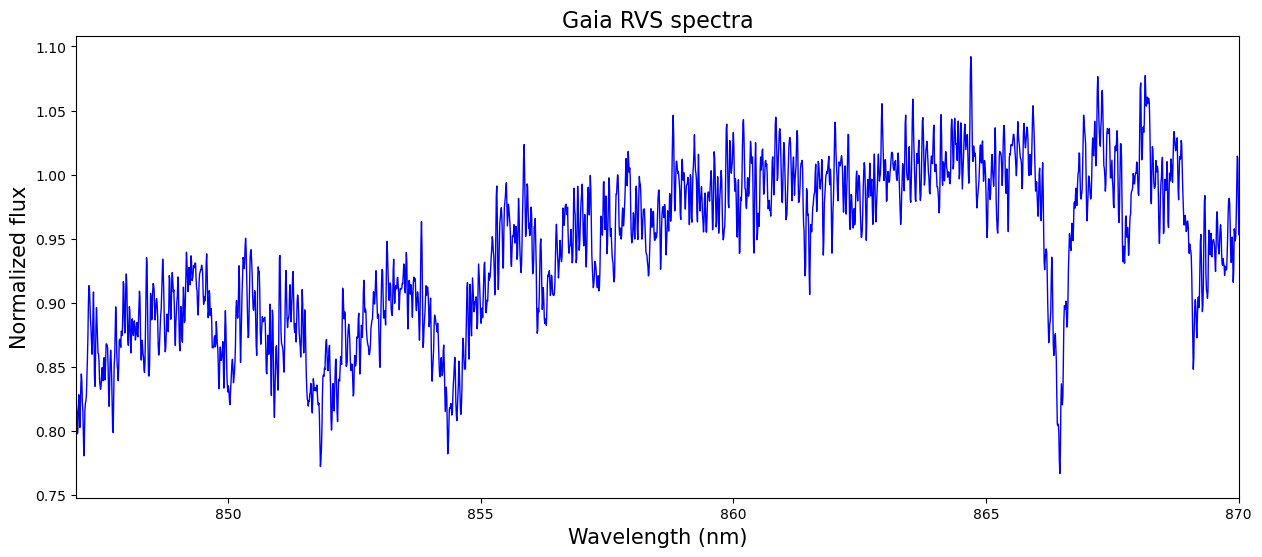

In [20]:
plt.figure(figsize=[15, 6])
plt.plot(star['lambd'], star['flux'], color='blue', linewidth=1)
plt.xlim(847,870)
plt.ylabel('Normalized flux', fontsize=15)
plt.xlabel('Wavelength (nm)', fontsize=15)
plt.title('Gaia RVS spectra', fontsize=16)

Text(0.5, 0, 'Wavelength (nm)')

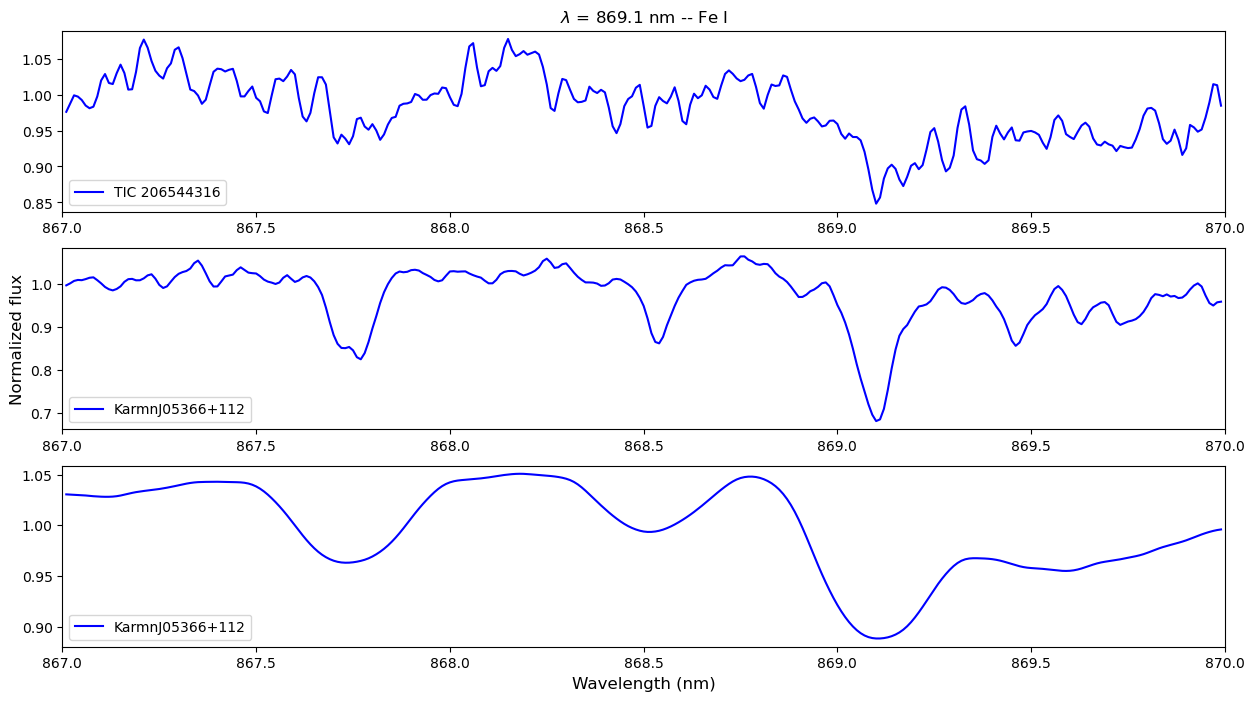

In [21]:
line_center = lines['Fe I'][1]
# wavmin = line_center - 1
# wavmax = line_center + 1

wavmin = 867
wavmax = 870

# Plot the spectrum
# fig, ax = plt.subplots(len(ref)+1, 1, figsize=[15,8])
fig, ax = plt.subplots(3, 1, figsize=[15,8])

starwav = star.loc[(star.lambd > wavmin) & (star.lambd < wavmax),"lambd"].values
starflux = star.loc[(star.lambd > wavmin) & (star.lambd < wavmax),"flux"].values
ax[0].plot(starwav, starflux, label='TIC 206544316', color='blue')
ax[0].set_xlim(wavmin, wavmax)
ax[0].legend(loc='lower left')
ax[0].set_title('$\lambda$ = {} nm -- {}'.format(line_center, get_key(line_center)))

i = 1

spec = ref['KarmnJ05366+112'][4]
wav = spec.loc[(spec.lambd > wavmin) & (spec.lambd < wavmax),"lambd"].values
flux = spec.loc[(spec.lambd > wavmin) & (spec.lambd < wavmax),"flux"].values

ax[1].plot(wav, flux, label='KarmnJ05366+112', color='blue')
ax[1].set_xlim(wavmin, wavmax)
ax[1].legend(loc='lower left')
ax[1].set_ylabel('Normalized flux', fontsize=12)

specs = broaden.rotational_convolution(wav, spec.lambd, spec.flux, 70, epsilon=0.75);

ax[2].plot(wav, specs/np.median(specs), label='KarmnJ05366+112', color='blue')
ax[2].set_xlim(wavmin, wavmax)
ax[2].legend(loc='lower left')
ax[2].set_xlabel('Wavelength (nm)', fontsize=12)
    
# plt.savefig('vsini_result/spectrum_{}.png'.format(line_center))

In [22]:
%%capture

# Get broaden spectra

# Iterate to all model spectra
for key, l in ref.items():

    # Pick up model
    model = l[4]

    # Constrain region of interest
    wav = model.loc[(model.lambd >wavmin) & (model.lambd < wavmax),"lambd"].values
    mflux = model.loc[(model.lambd > wavmin) & (model.lambd < wavmax),"flux"].values

    # Pick the v sin i
    vsinis = np.arange(20,120,.25)

    # Set up the wavelength grid
    specs = pd.DataFrame({"wav":wav})

    # Get grid for fit
    #-----------------------------

    # Broaden spectra
    for vsini in vsinis:
        specs[vsini] = broaden.rotational_convolution(wav, model.lambd, model.flux, vsini, epsilon=0.75)
    
    # Make the wavelength as index
    specs = specs.set_index("wav")

    # Filename
    file = '{}_{}_{}.csv'.format(key, wavmin, wavmax)

    # Convert to csv
    specs.to_csv('data/vsini_grid/{}'.format(file))

In [23]:
lagunit = (np.mean(np.diff(wav*10)) / (line_center*10) * lightspeed).to("km/s")

print(f"Resolution in velocity space: {lagunit:.2f}")

Resolution in velocity space: 3.45 km / s


vsini from KarmnJ05366+112 = 71.49 +/- 10.19 km/s
vsini from KarmnJ08526+283 = 66.28 +/- 9.93 km/s
vsini from KarmnJ10416+376 = 66.17 +/- 10.06 km/s
vsini from KarmnJ11509+483 = 67.60 +/- 9.23 km/s
----------------------
mean v sin i = 67.89 +/- 4.93 km/s


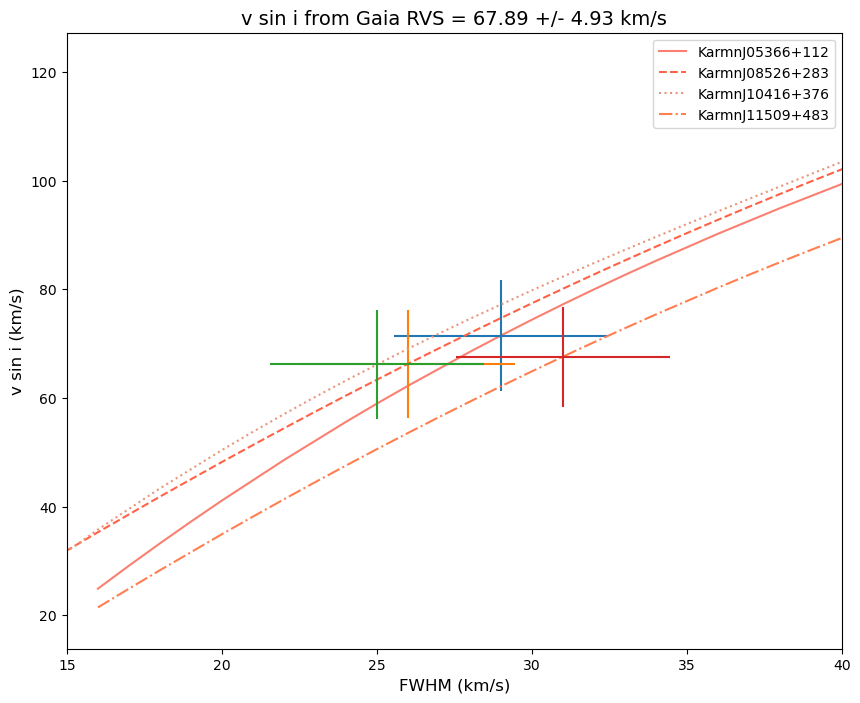

In [24]:
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=[10,8])

# Place to put results
res = {}

# Iterate to all model spectra
for key, l in ref.items():

    # Initialize for key
    res[key] = {}

    # Pick up model
    model = l[4]

    # Constrain region of interest
    wav = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"lambd"].values
    mflux = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"flux"].values

    # Get v sin i grid
    file = '{}_{}_{}.csv'.format(key, wavmin, wavmax)
    specs = pd.read_csv('data/vsini_grid/{}'.format(file))

    specs = specs.set_index('wav')
    
    # Cross-corelation function
    #-----------------------------

    # Convert spectral resolution to resolution in velocity space
    lagunit = (np.mean(np.diff(wav)) / line_center * lightspeed).to("km/s")

    # Set up CCF frame
    corrf = pd.DataFrame()

    # Define CC parameters
    maxlag = 200

    # Run CC
    for vsini in specs.columns.values:

        # Pick a broadened spectrum
        a = specs[vsini]

        # Run CC
        cc = correlate_maxlag(a, mflux, maxlag)

        # Save to CCF
        corrf[vsini] = cc

    # Get CCF for object
    cc1_star = correlate_maxlag(starflux, mflux, maxlag)

    # Convert CCF lag to velocity
    v_star = get_lags(cc1_star)*lagunit

    # Fit the CCF to get v sin i
    #-----------------------------

    # Calculate the FWHM for model spectrum
    FWHM = corrf.apply(lambda x:np.where(x>np.max(x)/2.)[0][-1]-np.where(x>np.max(x)/2.)[0][0], axis=0)
    FWHM = FWHM.sort_values()

    # Range of FWHM to fit
    wh = np.where(FWHM.values>0)[0]
    x, y = FWHM.index.astype(float).values[wh], FWHM.values[wh]

    # Fit 3rd order polynomial
    z = np.polyfit(y,x,3, cov=False)
    p = np.poly1d(z)

    # Derivative of polynomial fit to get uncertainty
    pdiv = np.polyder(p)

    plt.plot(y, p(y), label=key, color=l[2], linestyle=l[3])

    # Get FWHM from object
    overhalf = np.where(cc1_star > np.max(cc1_star)/2.)[0]
    fwhm = overhalf[-1] - overhalf[0]

    # y0 -> FWHM to get v sin i
    # ey0 -> spectral resolution that defines the FWHM uncertainty
    y0, ey0 = fwhm, lagunit.value

    # Uncertaintiy of v sin i
    dfwhm_dvsini = pdiv(y0)
    yerr = dfwhm_dvsini * ey0

    plt.errorbar(y0, p(y0), xerr=ey0, yerr=yerr, 
                 )

    print('vsini from {} = {:.2f} +/- {:.2f} km/s'.format(key, p(y0), yerr))

    res[key]['object'] = [p(y0),  yerr]

vsini_s = []
errors = []

for key, l in res.items():
    for key, obj in l.items():
        vsini_s.append(obj[0])
        errors.append(obj[1])

print('----------------------')

vsini_s = np.array(vsini_s)
errors = np.array(errors)

# v sin i error
sum_err = np.sum(errors**2)
err = np.sqrt(sum_err)/4

# Mean v sin i
print('mean v sin i = {:.2f} +/- {:.2f} km/s'.format(vsini_s.mean(),err))

plt.title('v sin i from Gaia RVS = {:.2f} +/- {:.2f} km/s'.format(vsini_s.mean(),err), fontsize=14)

# plt.text(23, 14, 'mean v sin i = {:.2f} +/- {:.2f} km/s'.format(vsini_s.mean(),err), 
#          fontsize=12)

plt.xlim(15, 40)
plt.legend()
plt.xlabel('FWHM (km/s)', fontsize=12)
plt.ylabel('v sin i (km/s)', fontsize=12)
# plt.title('Lambda = {} nm -- {}'.format(line_center, get_key(line_center)))
plt.savefig('output/inclination/vsini_GaiaRVS.png')